In [1]:
cd C:\Users\APOORVA\walmart\Healthcare Potential Fraud\dataset

C:\Users\APOORVA\walmart\Healthcare Potential Fraud\dataset


Importing required libraries

In [2]:
import os
import sys
import math
import scipy as scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Reading Dataset

In [3]:
Benificiary = pd.read_csv("Train_Beneficiarydata-1542865627584.csv")
Inpatient = pd.read_csv("Train_Inpatientdata-1542865627584.csv")
Outpatient = pd.read_csv("Train_Outpatientdata-1542865627584.csv")
Labels = pd.read_csv("Train-1542865627584.csv")

# Merging all data

In [4]:
# Adding New Feature - 1 :: Admitted or Not Admitted indicator in IP and OP Dataset
Inpatient["Admitted?"] = 1      #Inpatient: Patients who got Admitted
Outpatient["Admitted?"] = 0     #Outpatient: medical services provided without hospital admission

In [5]:
# Checking common columns in both data
n = [col for col in Inpatient.columns if col in Outpatient.columns]
# Merging the IP and OP dataset on the basis of common columns
IOpatient = pd.merge(left=Inpatient, right=Outpatient, left_on=n, right_on=n, how="outer")
IOpatient.shape

(558211, 31)

In [6]:
# Joining the IOpatient dataset with the Benificiary data
IOB = pd.merge(left=IOpatient, right=Benificiary, left_on='BeneID', right_on='BeneID',how='inner')
IOB.shape

(558211, 55)

In [7]:
# Joining the IP_OP_BENE dataset with the Tgt Label Provider Data
Data = pd.merge(left=IOB, right=Labels, left_on='Provider', right_on='Provider',how='inner')
Data.shape

(558211, 56)

In [8]:
# # Joining with the PRV Tgt Labels
# prvs_claims_df = pd.DataFrame(train_iobp_df.groupby(['Provider'])['ClaimID'].count()).reset_index()
# prvs_claims_tgt_lbls_df = pd.merge(left=prvs_claims_df, right=train_tgt_lbls_df, on='Provider', how='inner')
# prvs_claims_tgt_lbls_df

Data Cleaning (Removing Nulll Data Columns)

In [9]:
# Dropping these 5 columns as there 99% of values are same
Data.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6'], axis=1, inplace=True)

In [10]:
# Adding New Feature - 2 :: Alive?

Data['DOB'] = pd.to_datetime(Data['DOB'], format="%Y-%m-%d")
Data['DOD'] = pd.to_datetime(Data['DOD'], format="%Y-%m-%d")
Data['Alive?'] = Data['DOD'].apply(lambda val: 'No' if val != val else 'Yes')
Data['Alive?'].value_counts()

# Adding New Feature - 3 :: Claim_Duration

Data['ClaimStartDt'] = pd.to_datetime(Data['ClaimStartDt'], format="%Y-%m-%d")
Data['ClaimEndDt'] = pd.to_datetime(Data['ClaimEndDt'], format="%Y-%m-%d")

Data['Claim_Duration'] = (Data['ClaimEndDt'] - Data['ClaimStartDt']).dt.days

# Adding New Feature - 4 :: Admitted_Duration
Data['AdmissionDt'] = pd.to_datetime(Data['AdmissionDt'], format="%Y-%m-%d")
Data['DischargeDt'] = pd.to_datetime(Data['DischargeDt'], format="%Y-%m-%d")

Data['Admitted_Duration'] = (Data['DischargeDt'] - Data['AdmissionDt']).dt.days

# Adding New Feature - 5 :: Bene_Age
Data['DOD'].fillna(value=Data['DOD'].max(), inplace=True)
Data['Bene_Age'] = round(((Data['DOD'] - Data['DOB']).dt.days) / 365, 1)

# Adding New Feature - 6 :: Phy_Tot_Claims
# Total unique number of Attending Physicians
att_physicians_count = Data['AttendingPhysician'].nunique()

# Total unique number of Operating Physicians
opr_physicians_count = Data['OperatingPhysician'].nunique()

# Total unique number of Other Physicians
oth_physicians_count = Data['OtherPhysician'].nunique()

# Total number of claims for each Attending Physician
Data['Att_Phy_tot_claims'] = Data.groupby(['AttendingPhysician'])['ClaimID'].transform('count')

# Total number of claims for each Operating Physician
Data['Opr_Phy_tot_claims'] = Data.groupby(['OperatingPhysician'])['ClaimID'].transform('count')

# Total number of claims for each Other Physician
Data['Oth_Phy_tot_claims'] = Data.groupby(['OtherPhysician'])['ClaimID'].transform('count')

# Total claims for each type of Physician (Attending + Operating + Other)
Data['Phy_Tot_Claims'] = Data['Att_Phy_tot_claims'] + Data['Opr_Phy_tot_claims'] + Data['Oth_Phy_tot_claims']

# Drop intermediate columns
Data.drop(['Att_Phy_tot_claims', 'Opr_Phy_tot_claims', 'Oth_Phy_tot_claims'], axis=1, inplace=True)

# Adding New Feature - 7 :: Prv_Tot_Phys
# Calculate the total number of Attending Physicians for each Provider and store it in the 'Prv_Tot_Att_Phy' column
Data['Prv_Tot_Att_Phy'] = Data.groupby('Provider')['AttendingPhysician'].transform('count')

# Calculate the total number of Operating Physicians for each Provider and store it in the 'Prv_Tot_Opr_Phy' column
Data['Prv_Tot_Opr_Phy'] = Data.groupby('Provider')['OperatingPhysician'].transform('count')

# Calculate the total number of Other Physicians for each Provider and store it in the 'Prv_Tot_Oth_Phy' column
Data['Prv_Tot_Oth_Phy'] = Data.groupby('Provider')['OtherPhysician'].transform('count')

# Calculate the total number of physicians (Attending + Operating + Other) for each Provider and store it in the 'Prv_Tot_Phys' column
Data['Prv_Tot_Phys'] = Data['Prv_Tot_Att_Phy'] + Data['Prv_Tot_Opr_Phy'] + Data['Prv_Tot_Oth_Phy']

# Drop the intermediate columns 'Prv_Tot_Att_Phy', 'Prv_Tot_Opr_Phy', and 'Prv_Tot_Oth_Phy' to keep the DataFrame clean
Data.drop(['Prv_Tot_Att_Phy', 'Prv_Tot_Opr_Phy', 'Prv_Tot_Oth_Phy'], axis=1, inplace=True)

# Adding New Feature 8 - PRV_Tot_Admit_DCodes: Total Unique Claim Admit Codes used by a PROVIDER
Data['PRV_Tot_Admit_DCodes'] = Data.groupby('Provider')['ClmAdmitDiagnosisCode'].transform('nunique')

# Adding New Feature 9 - PRV_Tot_DGrpCodes: Total Unique Number of Diagnosis Group Codes used by a PROVIDER
Data['PRV_Tot_DGrpCodes'] = Data.groupby('Provider')['DiagnosisGroupCode'].transform('nunique')

# Adding New Feature 10 - PRV_Tot_Unq_DOB_Years: Total unique Date of Birth years of beneficiaries provided by a Provider
Data['PRV_Tot_Unq_DOB_Years'] = Data.groupby('Provider')['DOB'].transform(lambda x: x.dt.year.nunique())

# Adding New Feature 11 - PRV_Bene_Age_Sum: Sum of patients age treated by a Provider
Data['PRV_Bene_Age_Sum'] = Data.groupby('Provider')['Bene_Age'].transform('sum')

# Adding New Feature 12 - PRV_Insc_Clm_ReImb_Amt: Sum of Insc Claim Re-Imb Amount for a Provider
Data['PRV_Insc_Clm_ReImb_Amt'] = Data.groupby('Provider')['InscClaimAmtReimbursed'].transform('sum')

# Adding New Feature 13 - PRV_Tot_RKD_Patients: Total number of RKD Patients seen by a Provider
Data['RenalDiseaseIndicator'] = Data['RenalDiseaseIndicator'].map({'Y': 1, 'N': 0})
Data['PRV_Tot_RKD_Patients'] = Data.groupby('Provider')['RenalDiseaseIndicator'].transform('sum')

# Drop intermediate columns
Data.drop(['DOB'], axis=1, inplace=True)

# Drop RenalDiseaseIndicator if no longer needed
Data.drop(['RenalDiseaseIndicator'], axis=1, inplace=True)

In [11]:
# Filling null values in Admitted_Duration with 0 (as it will represent the patients were admitted for 0 days)
Data['Admitted_Duration'].fillna(value=0,inplace=True)

In [12]:
Data.shape

(558211, 61)

Adding Aggregated Features :: For every possible level

These aggregated features will help you understand the overall patterns and characteristics of each provider in the dataset. By grouping the data based on the "Provider" column and applying the sum function on the specified columns, you are calculating the total values for each provider across those columns.

In [13]:
# PRV Aggregate features

# PRV_CoPayment: Total deductible amount paid by all beneficiaries for each provider.
Data["PRV_CoPayment"] = Data.groupby('Provider')['DeductibleAmtPaid'].transform('sum')

# PRV_IP_Annual_ReImb_Amt: Total inpatient annual reimbursement amount for each provider.
Data["PRV_IP_Annual_ReImb_Amt"] = Data.groupby('Provider')['IPAnnualReimbursementAmt'].transform('sum')

# PRV_IP_Annual_Ded_Amt: Total inpatient annual deductible amount for each provider.
Data["PRV_IP_Annual_Ded_Amt"] = Data.groupby('Provider')['IPAnnualDeductibleAmt'].transform('sum')

# PRV_OP_Annual_ReImb_Amt: Total outpatient annual reimbursement amount for each provider.
Data["PRV_OP_Annual_ReImb_Amt"] = Data.groupby('Provider')['OPAnnualReimbursementAmt'].transform('sum')

# PRV_OP_Annual_Ded_Amt: Total outpatient annual deductible amount for each provider.
Data["PRV_OP_Annual_Ded_Amt"] = Data.groupby('Provider')['OPAnnualDeductibleAmt'].transform('sum')

# PRV_Admit_Duration: Total duration of all admissions for each provider.
Data["PRV_Admit_Duration"] = Data.groupby('Provider')['Admitted_Duration'].transform('sum')

# PRV_Claim_Duration: Total duration of all claims for each provider.
Data["PRV_Claim_Duration"] = Data.groupby('Provider')['Claim_Duration'].transform('sum')

In [14]:
def create_agg_feats(Data, grp_col, feat_name, operation='sum'):
    """
    Description :: This function is created for adding the aggregated features in the dataset for every level like:
        - Beneficiary
        - Attending Physician
        - Operating Physician
        - Other Physician and etc..
        
    Input Parameters :: It accepts below inputs:
        - Data : `pandas.DataFrame`
            - The DataFrame where the aggregated features will be added.
        
        - grp_col : `str`
            - It represents the feature or level at which you want to perform the aggregation.
        
        - feat_name : `str`
            - It represents the feature whose aggregated aspect you want to capture.
        
        - operation : `str`
            - It represents the aggregation operation you want to perform. (By default it is SUM)
    """
    feat_1 = feat_name + "_Insc_ReImb_Amt"
    Data[feat_1] = Data.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)

    feat_2 = feat_name + "_CoPayment"
    Data[feat_2] = Data.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)

    feat_3 = feat_name + "_IP_Annual_ReImb_Amt"
    Data[feat_3] = Data.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)

    feat_4 = feat_name + "_IP_Annual_Ded_Amt"
    Data[feat_4] = Data.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)

    feat_5 = feat_name + "_OP_Annual_ReImb_Amt"
    Data[feat_5] = Data.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)

    feat_6 = feat_name + "_OP_Annual_Ded_Amt"
    Data[feat_6] = Data.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)

    feat_7 = feat_name + "_Admit_Duration"
    Data[feat_7] = Data.groupby(grp_col)['Admitted_Duration'].transform(operation)

    feat_8 = feat_name + "_Claim_Duration"
    Data[feat_8] = Data.groupby(grp_col)['Claim_Duration'].transform(operation)

    return Data

In [15]:
# Create aggregated features for BENE level
Data = create_agg_feats(Data, grp_col='BeneID', feat_name="BENE")

# Create aggregated features for Attending Physician level
Data = create_agg_feats(Data, grp_col='AttendingPhysician', feat_name="ATT_PHY")

# Create aggregated features for Operating Physician level
Data = create_agg_feats(Data, grp_col='OperatingPhysician', feat_name="OPT_PHY")

# Create aggregated features for Other Physician level
Data = create_agg_feats(Data, grp_col='OtherPhysician', feat_name="OTH_PHY")

# Create aggregated features for Claim Admit Diagnosis Code level
Data = create_agg_feats(Data, grp_col='ClmAdmitDiagnosisCode', feat_name="Claim_Admit_Diag_Code")

# Create aggregated features for Diagnosis Group Code level
Data = create_agg_feats(Data, grp_col='DiagnosisGroupCode', feat_name="Diag_GCode")

In [16]:
# Create aggregated features for Diagnosis Codes columns
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_1', feat_name="Claim_DiagCode1")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_2', feat_name="Claim_DiagCode2")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_3', feat_name="Claim_DiagCode3")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_4', feat_name="Claim_DiagCode4")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_5', feat_name="Claim_DiagCode5")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_6', feat_name="Claim_DiagCode6")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_7', feat_name="Claim_DiagCode7")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_8', feat_name="Claim_DiagCode8")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_9', feat_name="Claim_DiagCode9")
Data = create_agg_feats(Data, grp_col='ClmDiagnosisCode_10', feat_name="Claim_DiagCode10")

# Create aggregated features for Medical Procedure Codes columns
Data = create_agg_feats(Data, grp_col='ClmProcedureCode_1', feat_name="Claim_ProcCode1")
Data = create_agg_feats(Data, grp_col='ClmProcedureCode_2', feat_name="Claim_ProcCode2")
Data = create_agg_feats(Data, grp_col='ClmProcedureCode_3', feat_name="Claim_ProcCode3")

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_2] = Data.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_3] = Data.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_7] = Data.groupby(grp_col)['Admitted_Duration'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_8] = Data.groupby(grp_col)['Claim_Duration'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_3] = Data.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_4] = Data.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is us

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_6] = Data.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_7] = Data.groupby(grp_col)['Admitted_Duration'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_5] = Data.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data[feat_6] = Data.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\2881322961.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is us

In [17]:
Data.shape

(558211, 220)

Adding Aggregated Features :: Based on various combinations of different levels in order to introduce their interactions in the dataset.

- PROVIDER <--> BENE <--> PHYSICIANS
- PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES
- PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES
- PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES
- PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES
- PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES
- PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES
- PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES and etc..

Reasoning :: The idea behind adding the aggregated features based on the combinations of various features is that many parties or entities might work together to make a medicare fraud. Thus, we need to capture interactions among them to better classify the fraudsters.

In [18]:
# CLAIM COUNTS FOR PROVIDER
Data["ClmCount_Provider"] = Data.groupby(['Provider'])['ClaimID'].transform('count')

# CLAIM COUNTS FOR PROVIDER AND BENEID
Data["ClmCount_Provider_BeneID"] = Data.groupby(['Provider', 'BeneID'])['ClaimID'].transform('count')

# CLAIM COUNTS FOR PROVIDER AND PHYSICIANS
Data["ClmCount_Provider_AttendingPhysician"] = Data.groupby(['Provider', 'AttendingPhysician'])['ClaimID'].transform('count')
Data["ClmCount_Provider_OtherPhysician"] = Data.groupby(['Provider', 'OtherPhysician'])['ClaimID'].transform('count')
Data["ClmCount_Provider_OperatingPhysician"] = Data.groupby(['Provider', 'OperatingPhysician'])['ClaimID'].transform('count')

# CLAIM COUNTS FOR PROVIDER AND DIAGNOSIS CODES
Data["ClmCount_Provider_ClmAdmitDiagnosisCode"] = Data.groupby(['Provider', 'ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_1"] = Data.groupby(['Provider', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_2"] = Data.groupby(['Provider', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_3"] = Data.groupby(['Provider', 'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_4"] = Data.groupby(['Provider', 'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_5"] = Data.groupby(['Provider', 'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_6"] = Data.groupby(['Provider', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_7"] = Data.groupby(['Provider', 'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_8"] = Data.groupby(['Provider', 'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_9"] = Data.groupby(['Provider', 'ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Data["ClmCount_Provider_ClmDiagnosisCode_10"] = Data.groupby(['Provider', 'ClmDiagnosisCode_10'])['ClaimID'].transform('count')
Data["ClmCount_Provider_DiagnosisGroupCode"] = Data.groupby(['Provider', 'DiagnosisGroupCode'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PHYSICIANS :: To get claim counts
Data["ClmCount_Provider_BeneID_AttendingPhysician"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_2"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_3"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_4"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_5"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_6"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_7"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_8"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_9"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_10"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_1"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_2"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_3"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_4"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_5"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_6"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_7"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_8"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_9"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_10"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician', 'ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_1"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_2"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_3"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_4"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_5"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_6"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_7"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_8"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_9"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_10"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PROCEDURE CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> DIAGNOSIS CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_4"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_5"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_6"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_7"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_8"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_9"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_10"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES :: To get claim counts
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_1', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_1', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_1', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_2', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_2', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_2', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_3', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_3', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_3', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_4', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_4', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_4', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_5', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_5', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_5', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_6', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_6', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_6', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_7', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_7', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_7', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_8', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_8', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_8', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_9', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_9', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_10', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_10', 'ClmProcedureCode_3'])['ClaimID'].transform('count')


C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider"] = Data.groupby(['Provider'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID"] = Data.groupby(['Provider', 'BeneID'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:8: PerformanceWarning: DataFrame is highly fragment

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_OtherPhysician"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_OperatingPhysician"] = Data.groupby(['Provider', 'BeneID', 'OperatingPhysician'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_6"] = Data.groupby(['Provider', 'BeneID', 'AttendingPhysician', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_7"] = Data.groupby(['Provider', 'BeneID', 'Attendin

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_2"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_3"] = Data.groupby(['Provider', 'BeneID', 'OtherPhysician', 'Cl

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_6"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_7"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
C:\Users\APOORVA

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_3"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_4', 'ClmProcedureCode_3'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDia

C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1"] = Data.groupby(['Provider', 'BeneID', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
C:\Users\APOORVA\AppData\Local\Temp\ipykernel_12220\1046506908.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Data["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2"] = Data.groupby(['Provider', 'BeneID', 'Clm

In [19]:
Data.shape

(558211, 322)

In [20]:
# Removing unwanted columns
remove_unwanted_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                      'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode',
                      'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
                      'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                      'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'DOD', 'State', 'County']

Data.drop(columns=remove_unwanted_columns, axis=1, inplace=True)

In [21]:
# Filling Nulls in Deductible Amt Paid by Patient
Data['DeductibleAmtPaid'].fillna(value=0, inplace=True)

In [22]:
# Binary encoding the categorical features --> 0 means No and 1 means Yes
Data['Gender'] = Data['Gender'].apply(lambda val: 0 if val == 2 else val)
Data['PotentialFraud'] = Data['PotentialFraud'].apply(lambda val: 0 if val == "No" else 1)
Data['Alive?'] = Data['Alive?'].apply(lambda val: 0 if val == "No" else 1)

Data['ChronicCond_Alzheimer'] = Data['ChronicCond_Alzheimer'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_Heartfailure'] = Data['ChronicCond_Heartfailure'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_KidneyDisease'] = Data['ChronicCond_KidneyDisease'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_Cancer'] = Data['ChronicCond_Cancer'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_ObstrPulmonary'] = Data['ChronicCond_ObstrPulmonary'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_Depression'] = Data['ChronicCond_Depression'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_Diabetes'] = Data['ChronicCond_Diabetes'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_IschemicHeart'] = Data['ChronicCond_IschemicHeart'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_Osteoporasis'] = Data['ChronicCond_Osteoporasis'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_rheumatoidarthritis'] = Data['ChronicCond_rheumatoidarthritis'].apply(lambda val: 0 if val == 2 else val)
Data['ChronicCond_stroke'] = Data['ChronicCond_stroke'].apply(lambda val: 0 if val == 2 else val)

In [23]:
# Encoding the Categorical features
Data = pd.get_dummies(Data,columns=['Gender', 'Race', 'Admitted?', 'Alive?'], drop_first=True)

In [24]:
pd.set_option('display.max_rows',310)

In [25]:
# Filling Nulls in the aggregated features
Data.fillna(value=0, inplace=True)

In [26]:
# Checking Nulls in the features
pd.DataFrame(Data.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0
ChronicCond_Diabetes,0


Entire Data Aggregation :: At provider level

In [27]:
Data = Data.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')

In [28]:
Data.shape

(5410, 297)

Data Seggregation

#### Creating separate sets of independent features and target column.

In [29]:
X = Data.drop(axis=1, columns=['Provider','PotentialFraud'])
y = Data['PotentialFraud']
X.shape, type(X), y.shape, type(y)

((5410, 295), pandas.core.frame.DataFrame, (5410,), pandas.core.series.Series)

In [30]:
X.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,...,ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_3,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_3,Gender_1,Race_2,Race_3,Race_5,Admitted?_1,Alive?_1
0,104640,5340.0,15,19,17,5,10,9,21,23,...,0.0,0.0,0.0,0.0,9,4,0,0,5,0
1,605670,66286.0,56,80,64,10,41,54,100,112,...,0.0,3.0,1.0,0.0,54,24,0,1,62,1
2,52170,310.0,64,88,50,16,41,63,105,108,...,0.0,0.0,0.0,0.0,46,24,5,0,0,1
3,280910,3700.0,426,680,507,165,295,485,799,895,...,0.0,0.0,0.0,0.0,511,262,10,0,0,4
4,33710,3264.0,26,40,22,12,16,29,49,51,...,0.0,0.0,0.0,0.0,34,14,0,0,3,1


In [31]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: PotentialFraud, dtype: int64

Train Test Split :: Creating TRAIN and VALIDATION sets.

In [32]:
from sklearn.model_selection import train_test_split as tts

In [33]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, stratify=y, random_state=39)
# Checking shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4328, 295), (1082, 295), (4328,), (1082,))

In [34]:
# Checking count of tgt labels in y_train
y_train.value_counts()

0    3923
1     405
Name: PotentialFraud, dtype: int64

In [35]:
# Checking count of tgt labels in y_test
y_test.value_counts()

0    981
1    101
Name: PotentialFraud, dtype: int64

Standardizing TRAIN & TEST sets
Bringing every feature into the same scale.

In [36]:
from sklearn.preprocessing import RobustScaler
# Standardize the data (train and test)
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)
X_train_std = robust_scaler.transform(X_train)
X_test_std = robust_scaler.transform(X_test)

Baseline Model Training

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

In [38]:
# Training the model with all features and hyper-parameterized values
rfc_3 = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=4, max_features=None,
                               min_samples_leaf=50, min_samples_split=50, class_weight='balanced',
                               random_state=49, min_weight_fraction_leaf=0.0, max_leaf_nodes=None,
                               min_impurity_decrease=0.0, ccp_alpha=0.0)
rfc_3.fit(X_train_std, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=None,
                       min_samples_leaf=50, min_samples_split=50,
                       n_estimators=30, random_state=49)

In [39]:
label_font_dict = {'size': 12, 'weight': 'bold'}
title_font_dict = {'size': 14, 'weight': 'bold'}

In [40]:
def pred_prob(clf, data): 
    """
    Description :: This function is created for storing the predicted probabability using the trained model.
    
    Input :: It accepts below input parameters :
      - clf : Trained model classifier
      - data : Dataset for which we want to generate the predictions
    """
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    """
    Description :: This function is created for calculating the AUC score on train and test data. And, plotting the ROC curve.
    
    Input :: It accepts below input parameters :
      - train_fpr : Train False +ve rate
      - train_tpr : Train True +ve rate
      - test_fpr : Test False +ve rate
      - test_tpr : Test True +ve rate
    """
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    with plt.style.context('seaborn-poster'):
      plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc), color='blue')
      plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc), color='red')
      plt.legend()
      plt.xlabel("False Positive Rate(FPR)", fontdict=label_font_dict)
      plt.ylabel("True Positive Rate(TPR)", fontdict=label_font_dict)
      plt.title("Area Under Curve", fontdict=title_font_dict)
      plt.grid(which='major', color='lightgrey', linestyle='--')
      plt.minorticks_on()
      plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    """
    Description :: This function is created for finding the best threshold value.
    """
    t = threshold[np.argmax(tpr * (1-fpr))]
    return t

def predict_with_best_t(proba, threshold):
    """
    Description :: This function is created for generating the predictions based on the best threshold value.
    """
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    """
    Description :: This function is created for plotting the confusion matrix of TRAIN and TEST sets.
    """
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='viridis')
        ax[0].set_title('Train Dataset Confusion Matrix', fontdict=title_font_dict)
        ax[0].set_xlabel("Predicted Label", fontdict=label_font_dict)
        ax[0].set_ylabel("Actual Label", fontdict=label_font_dict)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[1], cmap='summer')
        ax[1].set_title('Test Dataset Confusion Matrix', fontdict=title_font_dict)
        ax[1].set_xlabel("Predicted Label", fontdict=label_font_dict)
        ax[1].set_ylabel("Actual Label", fontdict=label_font_dict)
    
    plt.show()
    
    return train_prediction, test_prediction

In [41]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    """
    Description :: This function is created for performing the evaluation of the trained model.
    """
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    
    # calculate tpr, fpr using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("### Train AUC = {}".format(train_auc))
    test_auc = auc(test_fpr, test_tpr)
    print("### Test AUC = {}".format(test_auc))
    
    # plotting the ROC curve
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    # Best threshold value
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    # Plotting the confusion matrices
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    # Generating the F1-scores
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, train_f1_score, test_f1_score, best_t

### Train AUC = 0.9537916623395424
### Test AUC = 0.9580847993056185


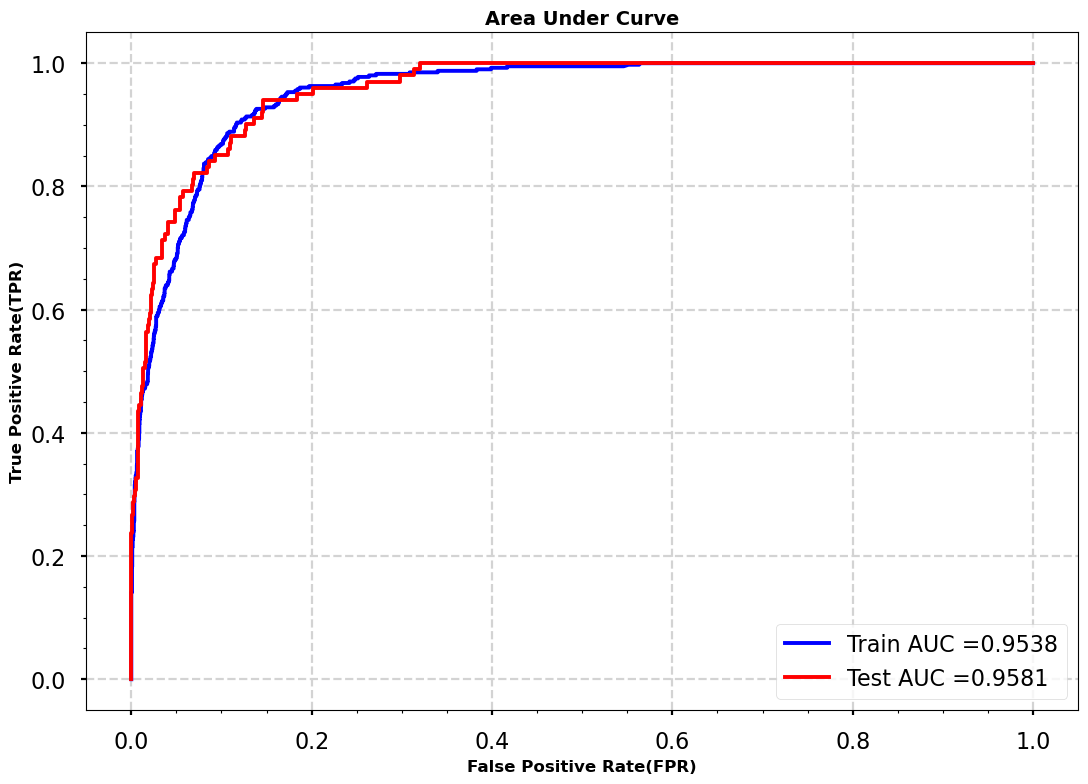

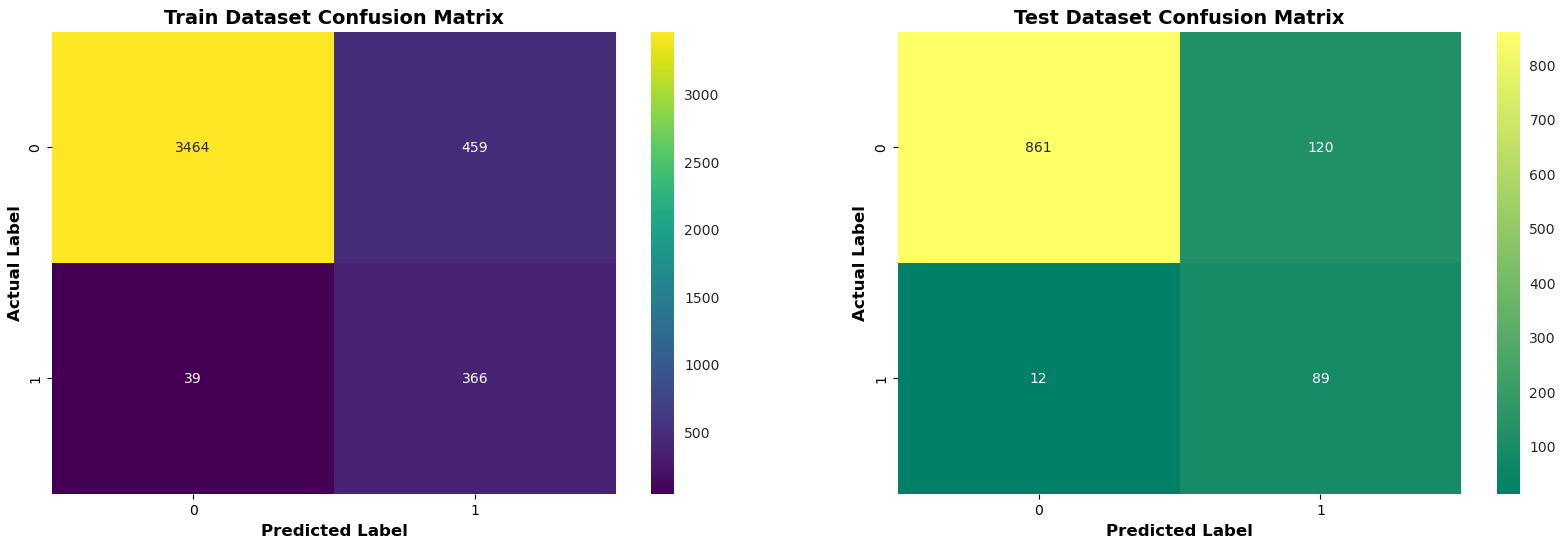



### Best Threshold = 0.5463
### Model AUC is : 0.9581
### Model Train F1 Score is : 0.5951
### Model Test F1 Score is : 0.5742


In [42]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc_3, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [43]:
# Get feature importances from the fitted model
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': rfc_3.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)

# Display feature importances
feats_imps

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.820495
1,DeductibleAmtPaid,0.003767
2,ChronicCond_KidneyDisease,0.000277
3,ChronicCond_Depression,0.000782
4,ChronicCond_stroke,0.000324
5,IPAnnualDeductibleAmt,0.000439
6,Claim_Duration,0.002582
7,Admitted_Duration,0.040917
8,Phy_Tot_Claims,0.000046
9,PRV_Tot_DGrpCodes,0.000213


In [44]:
top_20_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:20]
top_20_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:20]

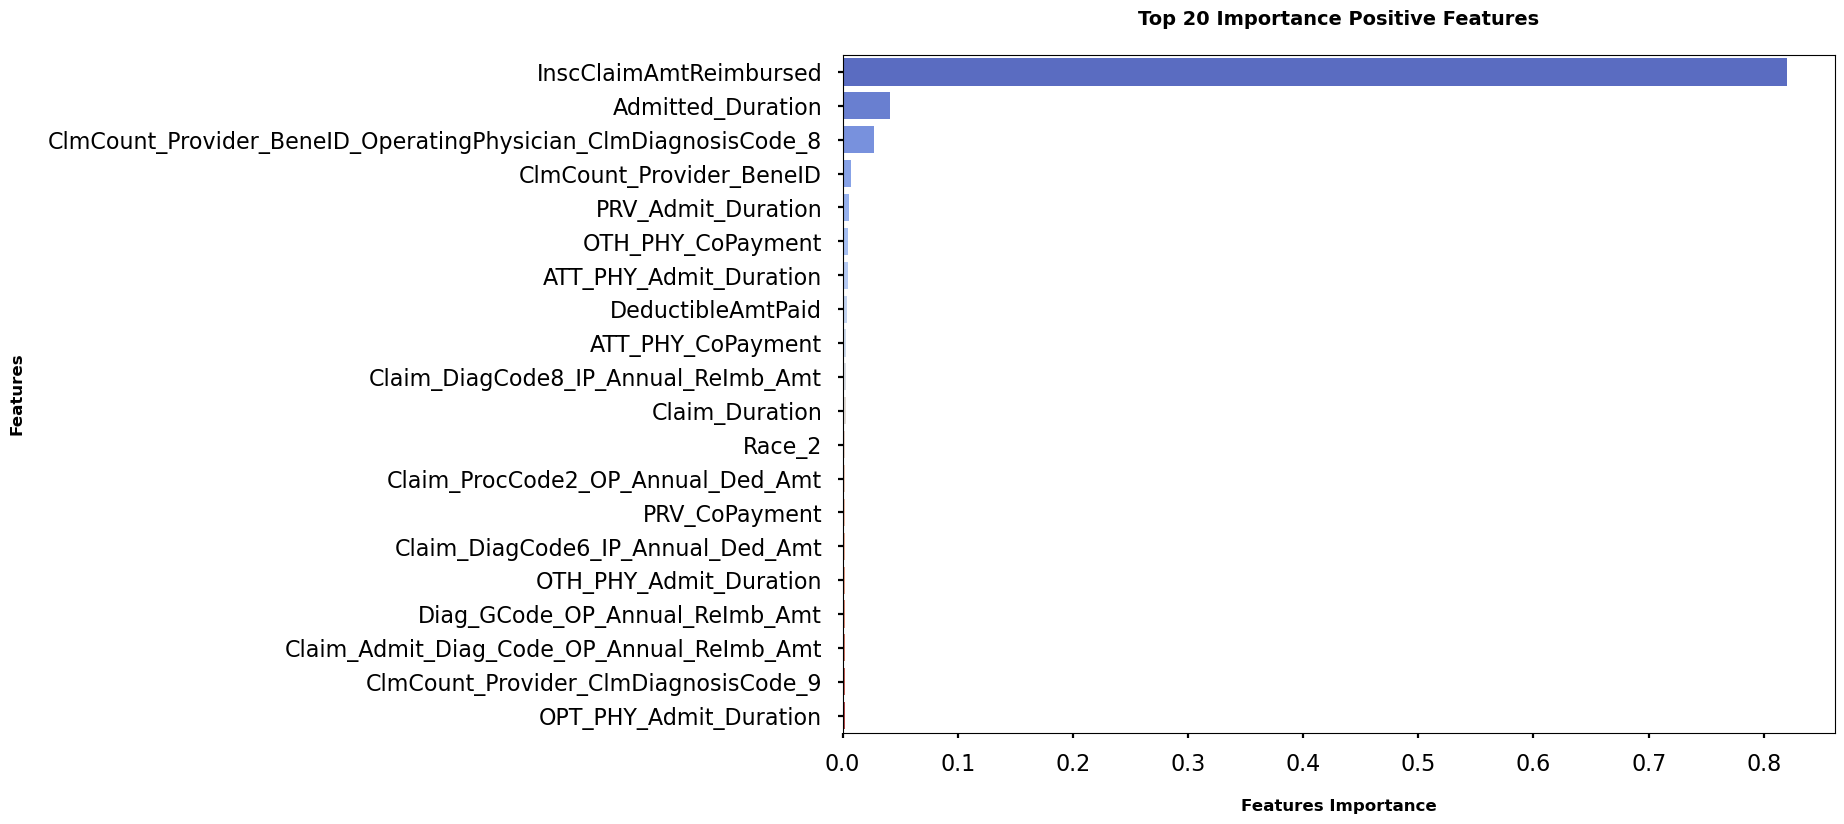

In [45]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_20_pos_feats, x=top_20_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 20 Importance Positive Features\n", fontdict=title_font_dict)